In [55]:
import pandas as pd
import networkx as nx
import os
import configparser
import itertools

In [21]:
config = configparser.ConfigParser()
config.read('rules.ini')

settings = {}
settings['path'] = config['RULES']['path']
settings['variation'] = config['RULES']['variation'][0]
settings['prop_variation'] = float(config['RULES']['variation'][1:])

In [44]:
path = r'C:\DanielBaron\GenerativeLSTM\output_files\20230417_3E8ABBDA_765B_4740_A305_D925CF5DE07C'
org_log_path = os.path.join(path, 'parameters', 'original_log.csv')

df_org = pd.read_csv(org_log_path)
df_org['start_timestamp'] = pd.to_datetime(df_org['start_timestamp'])
df_org['end_timestamp'] = pd.to_datetime(df_org['end_timestamp'])
df_org['rank'] = df_org.groupby('caseid')['start_timestamp'].rank().astype(int)

In [45]:
path = r'C:\DanielBaron\GenerativeLSTM\output_files\20230417_3E8ABBDA_765B_4740_A305_D925CF5DE07C'
gen_log_path = os.path.join(path, 'parameters', 'generated_log.csv')

df_gen = pd.read_csv(gen_log_path)
df_gen['start_timestamp'] = pd.to_datetime(df_gen['start_timestamp'])
df_gen['end_timestamp'] = pd.to_datetime(df_gen['end_timestamp'])
df_gen['rank'] = df_gen.groupby('caseid')['start_timestamp'].rank().astype(int)

In [46]:
ac_index = dict(zip(df_org.task, df_org.ac_index))

## Add edges

In [50]:
G = nx.DiGraph()
for value in ac_index.values():
    G.add_node(value)

In [80]:
graphs = []
for caseid in df_org['caseid'].drop_duplicates():

    df_tmp = df_org[df_org['caseid']==caseid]
    u_tasks = [ac_index[x] for x in df_tmp['task'].drop_duplicates()]
    
    G = nx.DiGraph()
    for task in u_tasks:
        G.add_node(task)

    tasks = list(df_tmp['task'])
    if list(df_tmp['rank']) == list(set(list(df_tmp['rank']))):
        order = [(ac_index[x[0]], ac_index[x[1]]) for x in [(a, b) for a, b in zip(tasks[:-1], tasks[1:])]]
    else:
        order = []
        for i in range(1, len(df_tmp['rank'])):
            c_task = list(df_tmp[df_tmp['rank']==i]['task'])
            n_task = list(df_tmp[df_tmp['rank']==i+1]['task'])
            order += [(ac_index[x[0]], ac_index[x[1]]) for x in list(itertools.product(c_task, n_task))]
    
    G.add_edges_from(order)
    graphs.append(G)

In [72]:
G.add_edges_from(seq_idx_tasks)

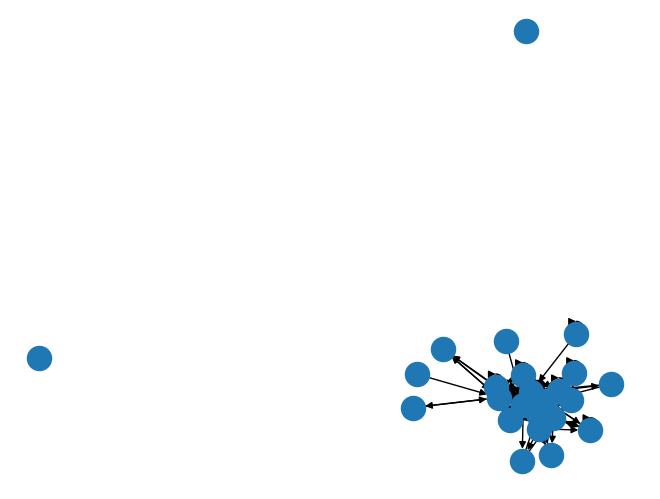

In [75]:
nx.draw(G)